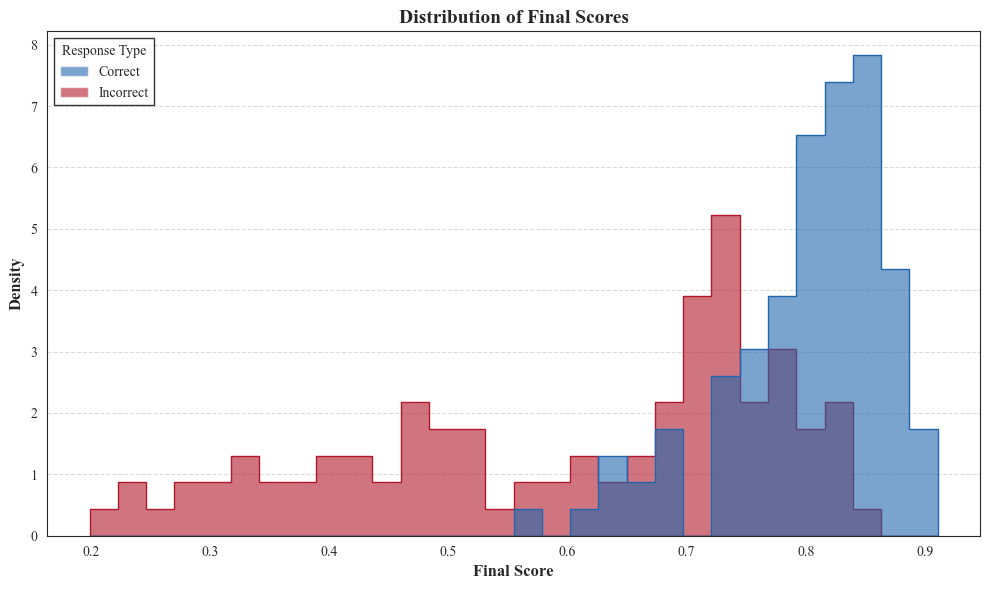

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from datasets import Dataset

# Load the datasets from Hugging Face Hub
correct_answer = load_dataset("RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-03-27-22-40-15-gpt-4o-mini-2024-07-18", split="train")
incorrect_answer = load_dataset("RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-03-28-10-20-06-gpt-4o-mini-2024-07-18", split="train")

# Extract the 'final score' columns from both datasets
scores_correct = correct_answer['Final_Score']
scores_incorrect = incorrect_answer['Final_Score']

# Create a combined DataFrame for visualization
df_correct = pd.DataFrame({'final score': scores_correct, 'dataset': 'Correct'})
df_incorrect = pd.DataFrame({'final score': scores_incorrect, 'dataset': 'Incorrect'})
combined_df = pd.concat([df_correct, df_incorrect], ignore_index=True)

# Set up the visualization with an academic-style theme
plt.figure(figsize=(10, 6))
sns.set_style("white")  # Clean, minimal style
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Create the histogram plot with explicit color mapping
colors = {'Correct': '#2166ac', 'Incorrect': '#b2182b'}
g = sns.histplot(
    data=combined_df, 
    x='final score', 
    hue='dataset', 
    element='step', 
    stat='density', 
    common_norm=False, 
    alpha=0.6, 
    bins=30, 
    palette=colors
)

# Add titles and labels with academic formatting
plt.title('Distribution of Final Scores', fontweight='bold')
plt.xlabel('Final Score', fontweight='bold')
plt.ylabel('Density', fontweight='bold')

# Manually create legend handles
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Correct'], alpha=0.6, label='Correct'),
    Patch(facecolor=colors['Incorrect'], alpha=0.6, label='Incorrect')
]

# Add legend with manually created handles
plt.legend(
    handles=legend_elements,
    title='Response Type', 
    title_fontsize=10, 
    frameon=True, 
    edgecolor='black', 
    fancybox=False
)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout and save
plt.tight_layout()
plt.savefig('../resource/score_distribution.png', dpi=300, bbox_inches='tight')

# Optional: show the plot (comment out if not needed)
plt.show()

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_similarity,
    answer_correctness
)
import dotenv

# Load environment variables from .env file
dotenv.load_dotenv()

# Load the datasets
correct_dataset = load_dataset(
    "RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-03-27-22-40-15-gpt-4o-mini-2024-07-18", 
    split="train"
)
incorrect_dataset = load_dataset(
    "RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-03-28-10-20-06-gpt-4o-mini-2024-07-18", 
    split="train"
)

# Prepare the datasets for Ragas evaluation.
def prepare_ragas_dataset(dataset, answer_col):
    data = {
        'question': dataset['question'],
        'answer': dataset[answer_col],
        'contexts': [[x] for x in dataset['documents']],  # Ensure this column exists in your dataset
        'ground_truth': dataset['response']  # Optional, adjust as needed
    }
    return Dataset.from_dict(data)

# Evaluate the correct and incorrect datasets with the defined metrics.
correct_metrics = evaluate(
    prepare_ragas_dataset(correct_dataset, 'Paraphrased'),
    metrics=[
        faithfulness,
        answer_relevancy,
        answer_correctness
    ]
)

incorrect_metrics = evaluate(
    prepare_ragas_dataset(incorrect_dataset, "Incorrect"),
    metrics=[
        faithfulness,
        answer_relevancy,
        answer_correctness
    ]
)

# Prepare data for visualization.
metrics_to_plot = [
    'faithfulness', 
    'answer_relevancy', 
    'answer_correctness'
]

plot_data = []
for metric in metrics_to_plot:
    plot_data.append({
        'Metric': metric,
        'Dataset': 'Correct',
        'Score': correct_metrics[metric]
    })
    plot_data.append({
        'Metric': metric,
        'Dataset': 'Incorrect',
        'Score': incorrect_metrics[metric]
    })

plot_df = pd.DataFrame(plot_data)
# plot_df.to_csv("ragas_dataset.csv", index=False)




Evaluating:   0%|          | 0/291 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/291 [00:00<?, ?it/s]

In [4]:
plot_df.to_csv("ragas_dataset.csv", index=False)

,Metric,Dataset,Score
0,faithfulness,Correct,"[0.5, 0.375, 0.8333333333333334, 1.0, 0.6, 0.9..."
1,faithfulness,Incorrect,"[0.46153846153846156, 0.375, 0.666666666666666..."
2,answer_relevancy,Correct,"[0.757720166675475, 0.9006939984036678, 0.8770..."
3,answer_relevancy,Incorrect,"[0.757720166675475, 0.9018133234349159, 0.8770..."
4,answer_correctness,Correct,"[0.8092777557383597, 0.9974518285758839, 0.934..."
5,answer_correctness,Incorrect,"[0.9387237844732066, 0.9474510632507904, 0.933..."


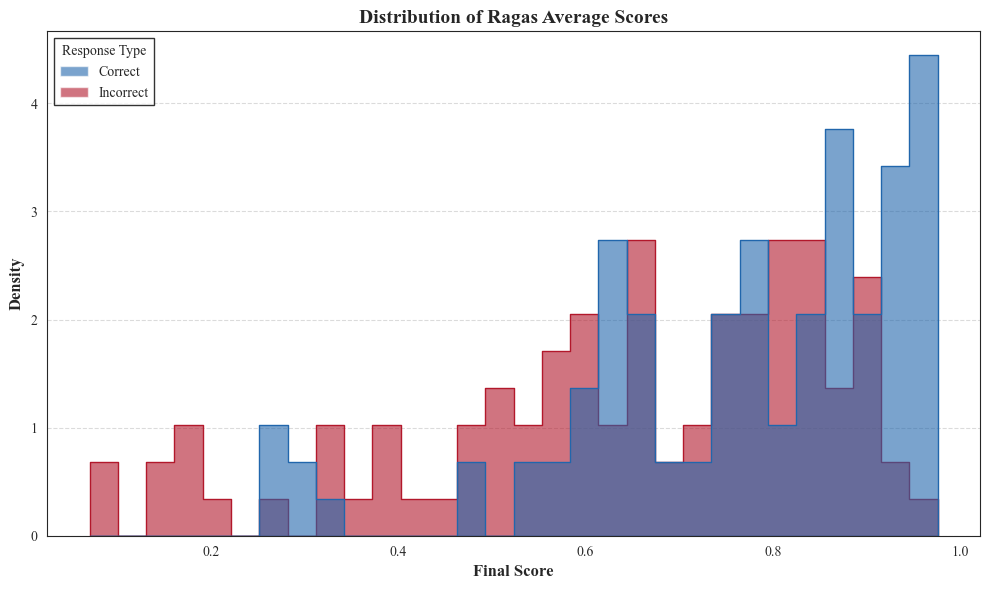

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume plot_df is your DataFrame with columns: ['Metric', 'Dataset', 'Score']
# and each row has a list of 96 scores in the 'Score' column

# Step 1: Expand the DataFrame so that each score gets its own row
plot_df_expanded = plot_df.reset_index().explode('Score').reset_index(drop=True)
plot_df_expanded['Score'] = plot_df_expanded['Score'].astype(float)

# Create a row index from 0 to 95 for each original row of scores
# 'OriginalRow' keeps track of the row number from the original DataFrame
plot_df_expanded['OriginalRow'] = plot_df_expanded.groupby('index').cumcount()

# Step 2: Compute the compound score (average over the 96 scores)
# Group by the original row (using the original DataFrame index) and Dataset,
# then calculate the mean of 'Score'
compound_scores = plot_df_expanded.groupby(['OriginalRow', 'Dataset'])['Score'].mean().reset_index()
compound_scores.rename(columns={'Score': 'Final Score'}, inplace=True)

# Step 3: Plot the distribution of the compound (final) scores using histplot
plt.figure(figsize=(10, 6))
sns.set_style("white")
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

colors = {'Correct': '#2166ac', 'Incorrect': '#b2182b'}
sns.histplot(
    data=compound_scores, 
    x='Final Score', 
    hue='Dataset', 
    element='step', 
    stat='density', 
    common_norm=False, 
    alpha=0.6, 
    bins=30, 
    palette=colors
)

plt.title('Distribution of Ragas Average Scores', fontweight='bold')
plt.xlabel('Final Score', fontweight='bold')
plt.ylabel('Density', fontweight='bold')

# Create manual legend handles
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Correct'], alpha=0.6, label='Correct'),
    Patch(facecolor=colors['Incorrect'], alpha=0.6, label='Incorrect')
]
plt.legend(
    handles=legend_elements,
    title='Response Type', 
    title_fontsize=10, 
    frameon=True, 
    edgecolor='black', 
    fancybox=False
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../resource/ragas_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
plot_df_expanded

,index,Metric,Dataset,Score,OriginalRow
0,0,faithfulness,Correct,0.500000,0
1,0,faithfulness,Correct,0.375000,1
2,0,faithfulness,Correct,0.833333,2
3,0,faithfulness,Correct,1.000000,3
4,0,faithfulness,Correct,0.600000,4
...,...,...,...,...,...
577,5,answer_correctness,Incorrect,0.446404,92
578,5,answer_correctness,Incorrect,0.993321,93
579,5,answer_correctness,Incorrect,0.764919,94
580,5,answer_correctness,Incorrect,0.988141,95


Generating train split:   0%|          | 0/97 [00:00<?, ? examples/s]

/var/folders/th/zffq3_bj3115zg2pzfz4hb0m0000gn/T/ipykernel_95273/804407941.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


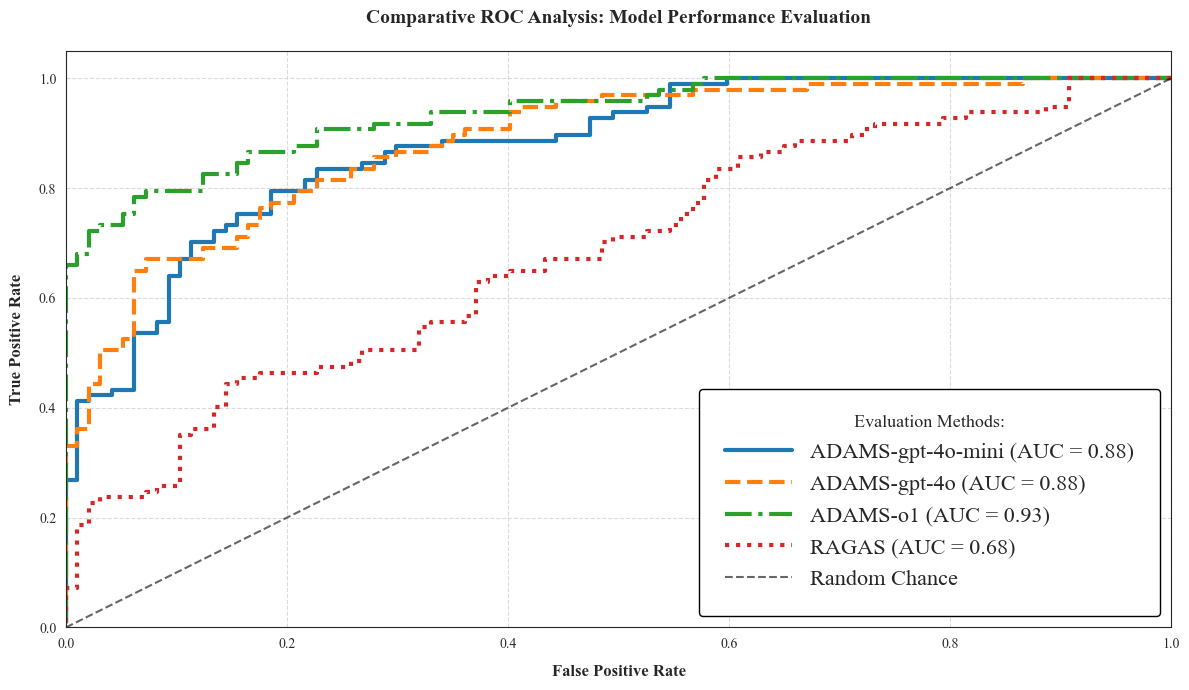

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Color palette configuration
MODEL_COLORS = {
    'gpt-4o-mini': '#1f77b4',
    'gpt-4o': '#ff7f0e',
    'o1': '#2ca02c',
    'RAGAS': '#d62728'
}

LINE_STYLES = {
    'gpt-4o-mini': 'solid',
    'gpt-4o': '--',
    'o1': '-.',
    'RAGAS': ':'
}

# Load and process all datasets
datasets = {
    'gpt-4o-mini': (
        load_dataset(
            "RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-03-27-22-40-15-gpt-4o-mini-2024-07-18",
            split="train"),
        load_dataset(
            "RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-03-28-10-20-06-gpt-4o-mini-2024-07-18",
            split="train")
    ),
    'gpt-4o': (
        load_dataset("RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-04-10-15-18-23-gpt-4o-2024-08-06",
                     split="train"),
        load_dataset("RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-04-12-13-44-07-gpt-4o-2024-08-06",
                     split="train")
    ),
    'o1': (
        load_dataset("RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-04-12-11-11-07-o1-2024-12-17",
                     split="train"),
        load_dataset("RAGEVALUATION-HJKMY/TSBC_100row_mistake_added-Evaluated-2025-04-12-11-49-12-o1-2024-12-17",
                     split="train")
    )
}

# Load RAGAS scores (assuming compound_scores exists from previous processing)
ragas_correct = compound_scores[compound_scores['Dataset'] == 'Correct']['Final Score'].values
ragas_incorrect = compound_scores[compound_scores['Dataset'] == 'Incorrect']['Final Score'].values


def calculate_roc(scores_pos, scores_neg):
    """Calculate ROC curve metrics"""
    y_true = np.concatenate([np.ones_like(scores_pos), np.zeros_like(scores_neg)])
    y_scores = np.concatenate([scores_pos, scores_neg])

    sorted_indices = np.argsort(y_scores)[::-1]
    y_sorted = y_true[sorted_indices]

    tps = np.cumsum(y_sorted)
    fps = np.cumsum(1 - y_sorted)

    tpr = tps / len(scores_pos)
    fpr = fps / len(scores_neg)
    auc = np.trapz(tpr, fpr)

    return fpr, tpr, auc


# Calculate metrics for all models
roc_data = {}
for model_name, (correct_ds, incorrect_ds) in datasets.items():
    scores_correct = np.array(correct_ds['Final_Score'], dtype=float)
    scores_incorrect = np.array(incorrect_ds['Final_Score'], dtype=float)
    roc_data[model_name] = calculate_roc(scores_correct, scores_incorrect)

# Add RAGAS metrics
roc_data['RAGAS'] = calculate_roc(ragas_correct, ragas_incorrect)

# Set up academic-style plot
plt.figure(figsize=(12, 7))
sns.set_style("white")
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Plot all curves
for model_name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr,
             color=MODEL_COLORS[model_name],
             linestyle=LINE_STYLES[model_name],
             lw=3,
             label=f'{("ADAMS-" if model_name != "RAGAS" else "") + model_name} (AUC = {auc:.2f})')

# Plot random chance reference
# Plot random chance reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', alpha=0.6)

# Formatting
plt.title('Comparative ROC Analysis: Model Performance Evaluation', fontweight='bold', pad=20)
plt.xlabel('False Positive Rate', fontweight='bold', labelpad=10)
plt.ylabel('True Positive Rate', fontweight='bold', labelpad=10)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Enhanced legend with larger text and precise positioning
legend = plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, 0),  # Adjusted anchor point
    frameon=True,
    edgecolor='black',
    title='Evaluation Methods:',
    title_fontsize='13',  # Increased title size
    fontsize='16',        # Increased label size
    handlelength=3,       # Longer legend lines
    borderpad=1.2,        # More padding around elements
    framealpha=1,
    facecolor='white'
)

# Add margin on the right for legend
plt.subplots_adjust(right=0.78)

# Add grid
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Save and show
plt.tight_layout()
plt.savefig('../resource/full_model_comparison_roc.png', dpi=300, bbox_inches='tight')
plt.show()